## RNN for Skyrmion trajectories prediction

**Imports**

In [38]:
# Standard imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import trackpy as tp
from tqdm import tqdm  # for progress bar

# import functions
from my_functions import *

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

**Read the data**

In [2]:
directory = 'Rec_EDGE_300K_1L_50MA.out'
data = pd.read_csv(directory + '/filled_trajectories.csv')
data = data.drop(data.columns[0], axis=1)
no_skyrmions = data[data['frame'] == 0].shape[0]

data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11995,26.838018,9158.734705,799.0,10.0
11996,92.153535,8909.539660,799.0,11.0
11997,160.675052,8812.401110,799.0,12.0
11998,156.663224,8600.194927,799.0,13.0


In [6]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Experiment 1: predict next frame

In [3]:
min_max_scaler_x = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()

data_scaled = data.copy()

data_scaled['x'] = min_max_scaler_x.fit_transform(np.reshape(data['x'].values.astype(float), (-1, 1)))
data_scaled['y'] = min_max_scaler_y.fit_transform(np.reshape(data['y'].values.astype(float), (-1, 1)))

data_scaled

,y,x,frame,particle
0,0.065298,0.003366,0.0,0.0
1,0.105854,0.008537,0.0,1.0
2,0.220930,0.001087,0.0,2.0
3,0.274271,0.005597,0.0,3.0
4,0.277575,0.010755,0.0,4.0
...,...,...,...,...
11995,0.079113,1.000000,799.0,10.0
11996,0.452300,0.972699,799.0,11.0
11997,0.843805,0.962057,799.0,12.0
11998,0.820883,0.938808,799.0,13.0


**Particles used for training**


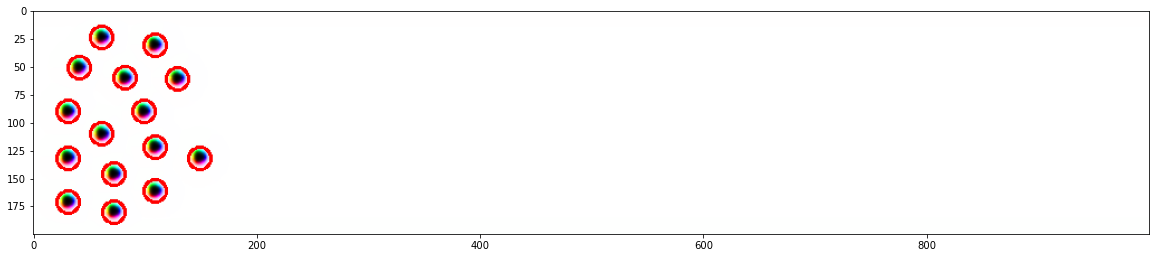

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 113.01it/s]


In [4]:
# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data, directory)

# format data so that it is in the format (frame, next_frame)
frames = np.array(get_frames(data_scaled))

# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

In [5]:
# split into train and test sets
train_size = int(len(frames) * 0.67)
test_size = len(frames) - train_size
train, test = frames[0:train_size,:], frames[train_size:len(frames),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [7]:
# choose a number of time steps
n_steps = 5
# convert into input/output
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [45]:
# define model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(SimpleRNN(512, activation='relu', return_sequences=True))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mae')

In [46]:
# fit model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=400, batch_size=10)

Train on 531 samples, validate on 259 samples
Epoch 1/400
531/531 [==============================] - 1s 2ms/step - loss: 0.1114 - val_loss: 0.1349
Epoch 2/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0396 - val_loss: 0.1164
Epoch 3/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0316 - val_loss: 0.1128
Epoch 4/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0296 - val_loss: 0.1261
Epoch 5/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0302 - val_loss: 0.1096
Epoch 6/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0275 - val_loss: 0.1136
Epoch 7/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0243 - val_loss: 0.1099
Epoch 8/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0223 - val_loss: 0.1096
Epoch 9/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0232 - val_loss: 0.1070
Epoch 10/400
531/531 [=======================

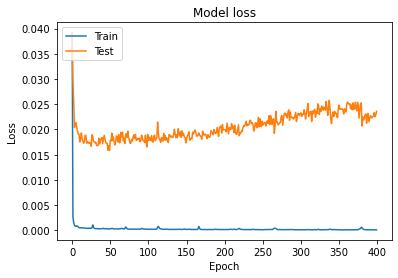

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [33]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [34]:
pred_train_df = get_predictions_df(pred_train)
pred_test_df = get_predictions_df(pred_test)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:04<00:00, 55.87it/s]


In [35]:
pred_train_unscaled = pred_train_df.copy()
pred_test_unscaled = pred_test_df.copy()

pred_train_unscaled['x'] = min_max_scaler_x.inverse_transform(np.reshape(pred_train_unscaled['x'].values.astype(float), (-1, 1)))
pred_train_unscaled['y'] = min_max_scaler_y.inverse_transform(np.reshape(pred_train_unscaled['y'].values.astype(float), (-1, 1)))

pred_test_unscaled['x'] = min_max_scaler_x.inverse_transform(np.reshape(pred_test_unscaled['x'].values.astype(float), (-1, 1)))
pred_test_unscaled['y'] = min_max_scaler_y.inverse_transform(np.reshape(pred_test_unscaled['y'].values.astype(float), (-1, 1)))

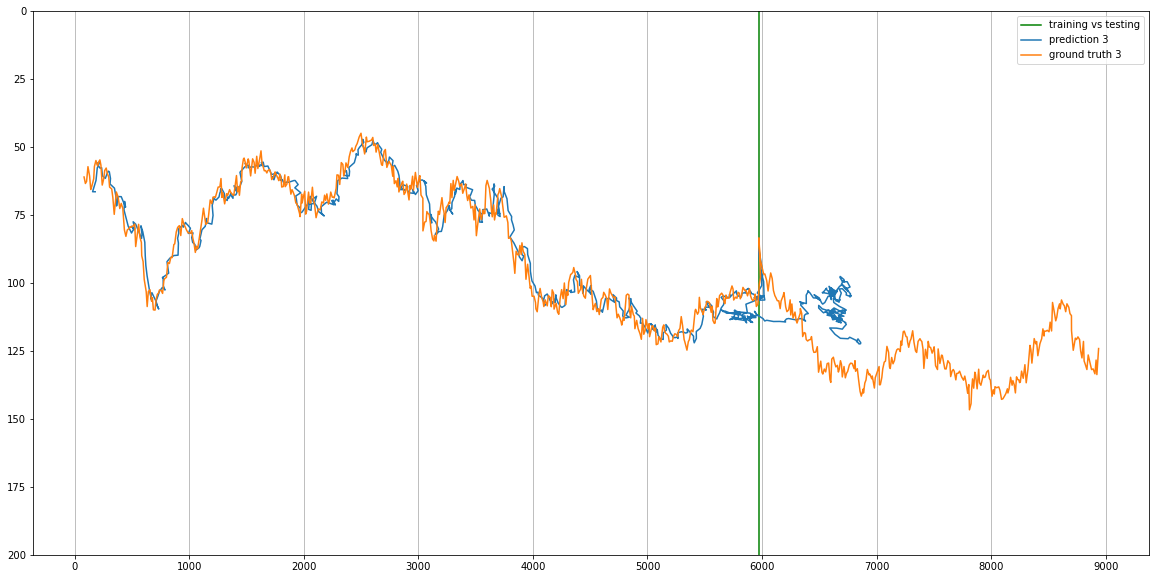

In [39]:
plot_prediction(data, pred_test_unscaled, pred_train_unscaled, ids=[3])

## Experiment 2: Predict single coordinate

In [116]:
particle = 0
coordinate = 'y'

coordinate_df = data[data['particle'] == particle][coordinate].reset_index(drop=True)
coordinate_df

0       24.420047
1       22.786106
2       23.797221
3       22.500377
4       22.045133
          ...    
795    162.759434
796    162.037060
797    162.559788
798    165.976863
799    161.975156
Name: y, Length: 800, dtype: float64

In [118]:
min_max_scaler = preprocessing.MinMaxScaler()

coordinates_scaled = coordinate_df.copy()

coordinates_scaled = min_max_scaler.fit_transform(np.reshape(coordinate_df.values.astype(float), (-1, 1)))

coordinates_scaled.shape

(800, 1)

In [119]:
# split into train and test sets
train_size = int(len(coordinates_scaled) * 0.67)
test_size = len(coordinates_scaled) - train_size
train, test = coordinates_scaled[0:train_size,:], coordinates_scaled[train_size:len(coordinates_scaled),:]
print(f'Train length: {len(train)}')
print(f'Test length: {len(test)}')

Train length: 536
Test length: 264


In [120]:
# choose a number of time steps
n_steps = 5
# convert into input/output
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

In [121]:
# define model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(SimpleRNN(512, activation='relu', return_sequences=True))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mae')

In [122]:
# fit model
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100)

Train on 531 samples, validate on 259 samples
Epoch 1/100
531/531 [==============================] - 1s 1ms/step - loss: 0.0993 - val_loss: 0.0258
Epoch 2/100
531/531 [==============================] - 0s 374us/step - loss: 0.0250 - val_loss: 0.0293
Epoch 3/100
531/531 [==============================] - 0s 408us/step - loss: 0.0275 - val_loss: 0.0293
Epoch 4/100
531/531 [==============================] - 0s 364us/step - loss: 0.0263 - val_loss: 0.0316
Epoch 5/100
531/531 [==============================] - 0s 347us/step - loss: 0.0224 - val_loss: 0.0331
Epoch 6/100
531/531 [==============================] - 0s 351us/step - loss: 0.0207 - val_loss: 0.0201
Epoch 7/100
531/531 [==============================] - 0s 347us/step - loss: 0.0201 - val_loss: 0.0156
Epoch 8/100
531/531 [==============================] - 0s 351us/step - loss: 0.0188 - val_loss: 0.0315
Epoch 9/100
531/531 [==============================] - 0s 357us/step - loss: 0.0213 - val_loss: 0.0266
Epoch 10/100
531/531 [=======

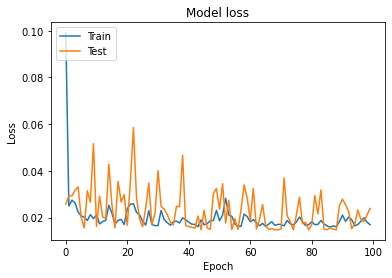

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [124]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [125]:
pred_train_unscaled = pred_train.copy()
pred_test_unscaled = pred_test.copy()

pred_train_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_train_unscaled.astype(float), (-1, 1)))

pred_test_unscaled = min_max_scaler.inverse_transform(np.reshape(pred_test_unscaled.astype(float), (-1, 1)))

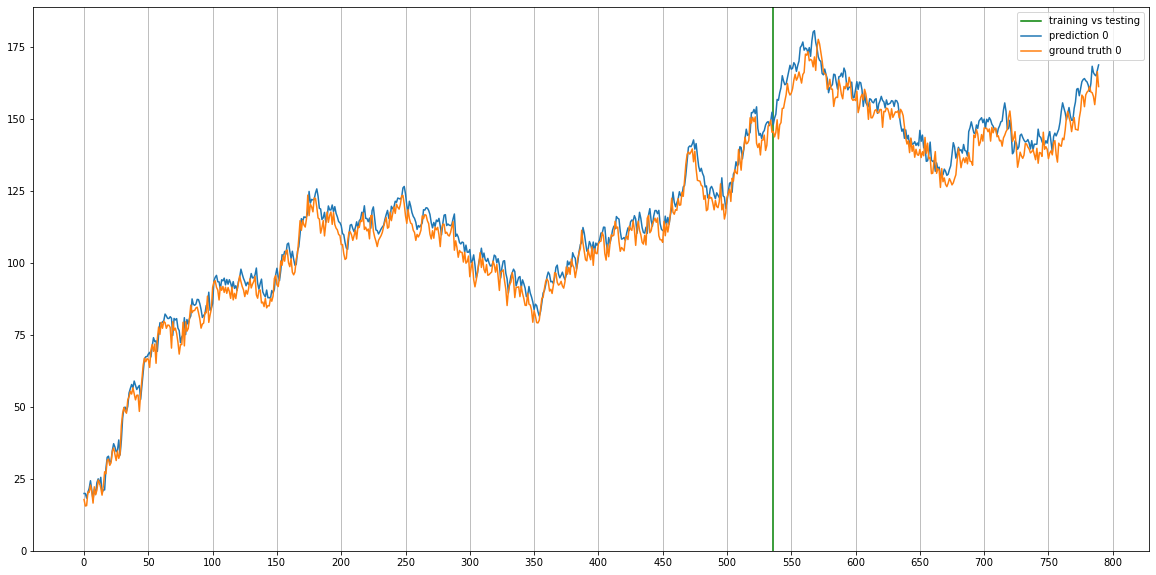

In [126]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, 801, 50))
plt.ylim(0, max(data[coordinate])+1)

plt.axvline(x=train_size, ymin=0, ymax=1, label='training vs testing', color='g')
y = np.concatenate((pred_train_unscaled, pred_test_unscaled))
x = np.arange(y.shape[0]).reshape((y.shape[0], 1))

plt.plot(x, y, label='prediction ' + str(particle), color='tab:blue')
plt.plot(x, data[data['particle'] == particle][coordinate][n_steps:-n_steps], label='ground truth ' + str(particle), color='tab:orange')

plt.legend()